<a href="https://colab.research.google.com/github/tanishraja21/Estimating-the-causal-effect-of-the-member-rewards-program/blob/main/Estimating_causal_effect_using_DoWhy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dowhy
!pip install econml
!apt install libgraphviz-dev
!pip install pygraphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Creating the dataset
import pandas as pd
import numpy as np
num_users = 10000
num_months = 12

signup_months = np.random.choice(np.arange(1, num_months), num_users) * np.random.randint(0,2, size=num_users) 
df = pd.DataFrame({
    'user_id': np.repeat(np.arange(num_users), num_months),
    'signup_month': np.repeat(signup_months, num_months), # signup month == 0 means customer did not sign up
    'month': np.tile(np.arange(1, num_months+1), num_users), # months are from 1 to 12
    'spend': np.random.poisson(500, num_users*num_months) 
})
# A customer is in the treatment group if and only if they signed up
df["treatment"] = df["signup_month"]>0
# Simulating an effect of month (monotonically decreasing--customers buy less later in the year)
df["spend"] = df["spend"] - df["month"]*10
# Simulating a simple treatment effect of 100
after_signup = (df["signup_month"] < df["month"]) & (df["treatment"])
df.loc[after_signup,"spend"] = df[after_signup]["spend"] + 100
df

,user_id,signup_month,month,spend,treatment
0,0,4,1,487,True
1,0,4,2,516,True
2,0,4,3,434,True
3,0,4,4,408,True
4,0,4,5,545,True
...,...,...,...,...,...
119995,9999,0,8,386,False
119996,9999,0,9,374,False
119997,9999,0,10,390,False
119998,9999,0,11,396,False


In [ ]:
import dowhy

# Setting the signup month
i = 3

In [ ]:
causal_graph = """digraph {
treatment[label="Program Signup in month i"];
pre_spends;
post_spends;
Z->treatment;
pre_spends -> treatment;
treatment->post_spends;
signup_month->post_spends;
signup_month->treatment;
}"""

# Post-process the data based on the graph and the month of the treatment (signup)
# For each customer, determine their average monthly spend before and after month i
df_i_signupmonth = (
    df[df.signup_month.isin([0, i])]
    .groupby(["user_id", "signup_month", "treatment"])
    .apply(
        lambda x: pd.Series(
            {
                "pre_spends": x.loc[x.month < i, "spend"].mean(),
                "post_spends": x.loc[x.month > i, "spend"].mean(),
            }
        )
    )
    .reset_index()
)
print(df_i_signupmonth)


      user_id  signup_month  treatment  pre_spends  post_spends
0           1             3       True       494.0   520.222222
1           4             0      False       482.0   408.444444
2           7             0      False       475.0   424.222222
3          11             0      False       530.0   418.111111
4          12             0      False       493.0   418.888889
...       ...           ...        ...         ...          ...
5449     9991             0      False       478.0   415.666667
5450     9992             0      False       502.0   425.888889
5451     9993             0      False       466.0   412.000000
5452     9998             0      False       497.5   427.666667
5453     9999             0      False       472.0   419.000000

[5454 rows x 5 columns]


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


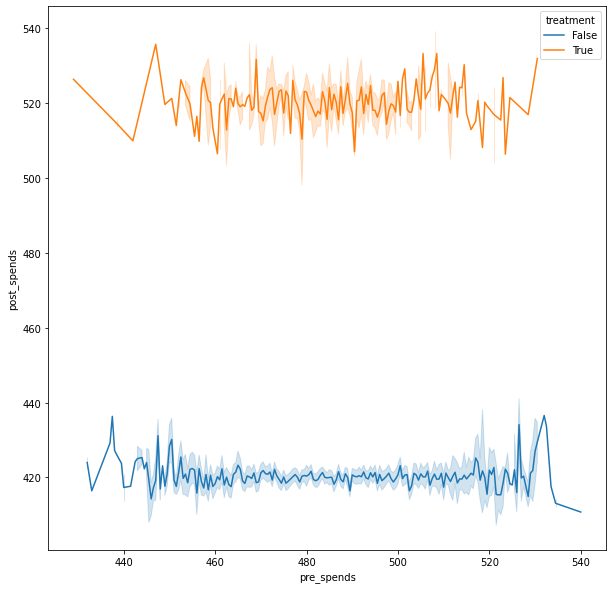

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
sns.lineplot(df_i_signupmonth['pre_spends'], df_i_signupmonth['post_spends'], hue=df_i_signupmonth['treatment'])
plt.show()
#df_i_signupmonth

__As significant difference is observed between pre and post spend, we think the rewards program is causing this change.__

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


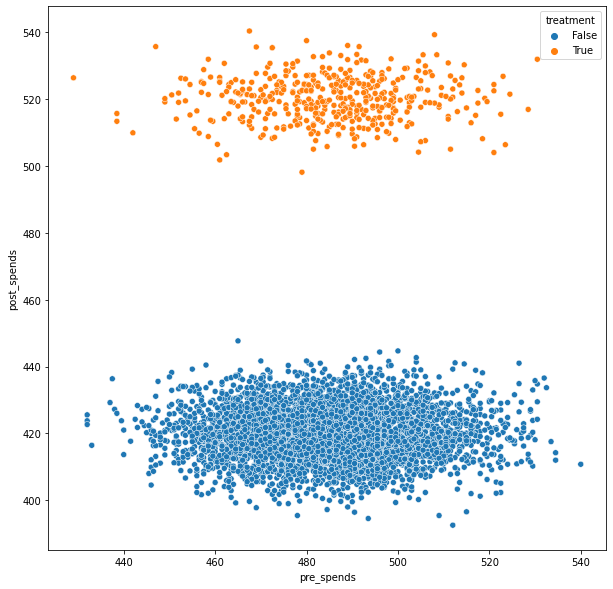

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(df_i_signupmonth['pre_spends'], df_i_signupmonth['post_spends'], hue=df_i_signupmonth['treatment'])
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


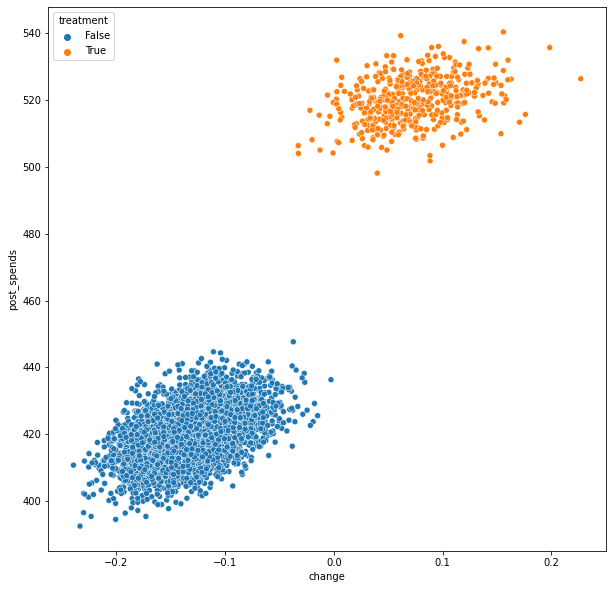

In [ ]:
df_i_signupmonth['change'] = (df_i_signupmonth['post_spends'] - df_i_signupmonth['pre_spends'])/df_i_signupmonth['pre_spends'] 

plt.figure(figsize=(10,10))
sns.scatterplot(df_i_signupmonth['change'], df_i_signupmonth['post_spends'], hue=df_i_signupmonth['treatment'])
plt.show()



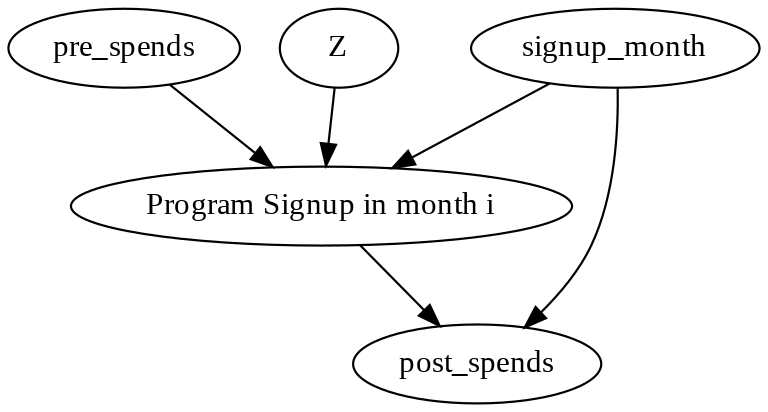

,user_id,signup_month,treatment,pre_spends,post_spends
0,1,3,True,494.0,520.222222
1,4,0,False,482.0,408.444444
2,7,0,False,475.0,424.222222
3,11,0,False,530.0,418.111111
4,12,0,False,493.0,418.888889
...,...,...,...,...,...
5449,9991,0,False,478.0,415.666667
5450,9992,0,False,502.0,425.888889
5451,9993,0,False,466.0,412.000000
5452,9998,0,False,497.5,427.666667


In [ ]:
model = dowhy.CausalModel(data=df_i_signupmonth,
                     graph=causal_graph.replace("\n", " "),
                     treatment="treatment",
                     outcome="post_spends")
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))
df_i_signupmonth

## II. Identifying the causal effect


In [ ]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(E[post_spends|signup_month])
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,U) = P(post_spends|treatment,signup_month)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                             -1⎤
 ⎢       d                      ⎛       d                     ⎞  ⎥
E⎢────────────────(post_spends)⋅⎜────────────────([treatment])⎟  ⎥
 ⎣d[pre_spends  T]              ⎝d[pre_spends  T]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→post_spends then ¬(U →→{pre_spends,T})
Estimand assumption 2, Exclusion: If we remove {pre_spends,T}→{treatment}, then ¬({pre_spends,T}→post_spends)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## III. Estimating the effect


In [ ]:
estimate = model.estimate_effect(identified_estimand, 
                                 method_name="backdoor.propensity_score_matching",
                                target_units="att")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(E[post_spends|signup_month])
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,U) = P(post_spends|treatment,signup_month)

## Realized estimand
b: post_spends~treatment+signup_month
Target units: att

## Estimate
Mean value: 95.81530864197525



In [ ]:
## Backdoor Propensity score weighting
estimate=model.estimate_effect(identified_estimand,method_name='backdoor.propensity_score_weighting',target_units="att")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(E[post_spends|signup_month])
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,U) = P(post_spends|treatment,signup_month)

## Realized estimand
b: post_spends~treatment+signup_month
Target units: att

## Estimate
Mean value: 99.95224353850267



## IV. Refuting the estimate


In [ ]:
refutation = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter",
                     placebo_type="permute", num_simulations=30,show_progress_bar=True)
print(refutation)

Refuting Estimates:   0%|          | 0/30 [00:00<?, ?it/s]

             Note: The underlying distribution may not be Normal. We assume that it approaches normal with the increase in sample size.


Refute: Use a Placebo Treatment
Estimated effect:99.95224353850267
New effect:-88.3546602677314
p value:0.0



Removing a random subset of the data

In [ ]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", show_progress_bar=True, subset_fraction=0.9)
print(res_subset)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refute: Use a subset of data
Estimated effect:99.95224353850267
New effect:99.9564405885276
p value:0.94

